In [1]:
import os
os.chdir('..')

In [2]:
import torch
import torch.nn.functional as F
from prednet import PredNet, PredNetTied
from dataset import load_dataset
from helpers import generate_adversarial, extract_features, rep_path

In [3]:
dataset = 'MNIST'
#dataset = 'CIFAR10'
is_adversarial = False

In [4]:
cls = 6
batch_size = 128

In [5]:
if dataset == 'MNIST':
    n_classes = 10
    n_input_channels = 1
    ckpt = 'checkpoint/PredNet_MNIST_0.01LR_6CLS_2REP_best_ckpt.t7'
elif dataset == 'CIFAR10':
    n_classes = 10
    n_input_channels = 3
    ckpt = 'checkpoint/PredNet_0.01LR_6CLS_1REP_best_ckpt.t7'

In [6]:
(trainset, testset), (trainloader, testloader), n_input_channels, n_classes  = load_dataset(dataset, batch_size)

In [7]:
ics = [n_input_channels,  32] # input channels
ocs = [32, 64] # output channels
sps = [False, False] # downsample flag
net = PredNet(num_classes=n_classes,cls=cls,ics=ics,ocs=ocs,sps=sps)

In [8]:
state_dict = torch.load(ckpt)['state_dict']
epoch = torch.load(ckpt)['epoch']
keys = list(state_dict.keys())
for key in keys:
    # Remove 'module.' in the keys.
    state_dict[key.replace('module.','')] = state_dict.pop(key)

In [9]:
net.load_state_dict(state_dict)
device = torch.device('cuda')
net.to(device)
net.eval()

PredNet(
  (FFconv): ModuleList(
    (0): FFconv2d(
      (conv2d): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): FFconv2d(
      (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (FBconv): ModuleList(
    (0): FBconv2d(
      (convtranspose2d): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): FBconv2d(
      (convtranspose2d): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (a0): ParameterList(  (0): Parameter containing: [torch.float32 of size 1x32x1x1 (cuda:0)])
  (b0): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x32x1x1 (cuda:0)]
      (1): Parameter containing: [torch.float32 of size 1x64x1x1 (cuda:0)]
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (linear): ModuleList(
    (0):

In [10]:
import torch.nn as nn
from torch.autograd import Variable

criterion = nn.CrossEntropyLoss()

print('\nTEST')
use_cuda = True
net.eval()
test_loss = 0
correct = 0
total = 0
layers = ['conv1', 'conv2', 'fc1', 'fc2']
dict_features = {t:{'conv1':list(), 'conv2':list()} for t in range(cls+1)}
dict_features_last = {'fc1':list(), 'fc2':list()}
labels = list()
for batch_idx, (inputs, targets) in enumerate(testloader):
    activation = {}
    def get_activation(name):
        def hook(net, input, output):
            activation[name] = output.detach()
        return hook

    net.FFconv[0].conv2d.register_forward_hook(get_activation('conv1'))
    net.FFconv[1].conv2d.register_forward_hook(get_activation('conv2'))
    net.fc1.register_forward_hook(get_activation('fc1'))
    net.fc2.register_forward_hook(get_activation('fc2'))
    net.FFconv.register_forward_hook(get_activation('FFconv'))
    
    if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs, volatile=False, requires_grad=False), Variable(targets, requires_grad=False)
    if is_adversarial:
        inputs = generate_adversarial(net, inputs, targets)
    with torch.no_grad():    
        outputs = net(inputs, r_history=True)
    loss = criterion(outputs, targets)

    activation['xrt'] = net.xrt

    test_loss += loss
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()

    for t, xrt in enumerate(activation['xrt']):
        for l, xr in enumerate(xrt):
            dict_features[t][f'conv{l+1}'] += [xr]
    dict_features_last['fc1'].append(activation['fc1'])
    dict_features_last['fc2'].append(activation['fc2'])
    labels.append(targets)

    input_last_1 = inputs


statstr = 'Testing: Epoch=%d | Loss: %.3f |  Acc: %.3f%% (%d/%d)' \
          % (epoch, test_loss/(batch_idx+1), 100.*(float)(correct)/(float)(total), correct, total)
print(statstr+'\n')


TEST
Testing: Epoch=96 | Loss: 0.019 |  Acc: 99.610% (9961/10000)



In [11]:
print('#TemporalRepresentations:', len(activation['xrt']))
print(' - #FF-FB-Cycles:', len(activation['xrt'])-1)
if len(activation['xrt']) > 0:
    print('#Layers:', len(activation['xrt'][0]))

#TemporalRepresentations: 7
 - #FF-FB-Cycles: 6
#Layers: 2


In [12]:
len(dict_features[2]['conv1'])

79

In [13]:
len(dict_features[2]['conv1'][0])

128

In [14]:
dict_features[2]['conv1'][0].shape

torch.Size([128, 32, 28, 28])

In [15]:
for t in dict_features.keys():
    for l in dict_features[t].keys():
        dict_features[t][l] = torch.concat(dict_features[t][l], dim=0)

In [16]:
t, l

(6, 'conv2')

In [17]:
for k in dict_features_last.keys():
    dict_features_last[k] = torch.concat(dict_features_last[k], dim=0)

In [18]:
labels = torch.concat(labels, dim=0)
print('labels.shape', labels.shape)

labels.shape torch.Size([10000])


In [19]:
dict_features[0]['conv1'].shape

torch.Size([10000, 32, 28, 28])

In [20]:
dict_features[0]['conv2'].shape

torch.Size([10000, 64, 28, 28])

In [21]:
dict_features[6]['conv1'].shape

torch.Size([10000, 32, 28, 28])

In [22]:
dict_features[6]['conv2'].shape

torch.Size([10000, 64, 28, 28])

In [23]:
dict_features_last['fc1'].shape

torch.Size([10000, 128])

In [24]:
dict_features_last['fc2'].shape

torch.Size([10000, 10])

In [25]:
dict_features_last['softmax'] = F.softmax(dict_features_last['fc2'], dim=-1)

# MNIST feedforward model

In [26]:
from helpers import model_download

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    """
    A neural network model for image classification, consisting of two convolutional layers,
    followed by two fully connected layers with dropout regularization.

    Methods:
    - forward(input): Defines the forward pass of the network.
    """

    def __init__(self):
        """
        Initializes the network layers.

        Layers:
        - conv1: First convolutional layer with 1 input channel, 32 output channels, and a 3x3 kernel.
        - conv2: Second convolutional layer with 32 input channels, 64 output channels, and a 3x3 kernel.
        - dropout1: Dropout layer with a dropout probability of 0.25.
        - dropout2: Dropout layer with a dropout probability of 0.5.
        - fc1: First fully connected layer with 9216 input features and 128 output features.
        - fc2: Second fully connected layer with 128 input features and 10 output features.
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, input):
        """
        Defines the forward pass of the network.

        Inputs:
        - input (torch.Tensor): Input tensor of shape (batch_size, 1, height, width).

        Outputs:
        - output (torch.Tensor): Output tensor of shape (batch_size, 10) representing the class probabilities for each input sample.
        """
        x = self.conv1(input)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

In [28]:
model_download()

In [29]:
net_ff = torch.load("standard_model.pth", map_location=torch.device("cuda"))

In [30]:
net_ff

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [31]:
import torch.nn as nn
from torch.autograd import Variable

criterion = nn.CrossEntropyLoss()

print('\nTEST')
use_cuda = True
net.eval()
test_loss = 0
correct = 0
total = 0
return_layers = ['input', 'conv1', 'conv2', 'fc1', 'fc2']
dict_features_ff = None
labels = list()
for batch_idx, (inputs, targets) in enumerate(testloader):
    if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs, volatile=False, requires_grad=False), Variable(targets, requires_grad=False)
    if is_adversarial:
        inputs = generate_adversarial(net, inputs, targets)
    with torch.no_grad():    
        outputs = net_ff(inputs)
        features = extract_features(net_ff, inputs, return_layers)
    loss = criterion(outputs, targets)

    test_loss += loss
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()

    
    for layer in features.keys():
        if dict_features_ff is None:
            dict_features_ff = dict()
        if layer not in dict_features_ff.keys():
            dict_features_ff[layer] = list()
        dict_features_ff[layer].append(features[layer])
    labels.append(targets)

    input_last_2 = inputs

statstr = 'Testing: Epoch=%d | Loss: %.3f |  Acc: %.3f%% (%d/%d)' \
          % (epoch, test_loss/(batch_idx+1), 100.*(float)(correct)/(float)(total), correct, total)
print(statstr+'\n')


TEST
Testing: Epoch=96 | Loss: 1.477 |  Acc: 98.720% (9872/10000)



In [32]:
dict_features_ff.keys()

dict_keys(['input', 'conv1', 'conv2', 'fc1', 'fc2'])

In [33]:
for layer in dict_features_ff.keys():
    dict_features_ff[layer] = torch.concat(dict_features_ff[layer], dim=0)
    print(f'dict_features_ff[{layer}].shape', dict_features_ff[layer].shape)

dict_features_ff[input].shape torch.Size([10000, 1, 28, 28])
dict_features_ff[conv1].shape torch.Size([10000, 32, 26, 26])
dict_features_ff[conv2].shape torch.Size([10000, 64, 24, 24])
dict_features_ff[fc1].shape torch.Size([10000, 128])
dict_features_ff[fc2].shape torch.Size([10000, 10])


In [34]:
dict_features_ff['softmax'] = F.softmax(dict_features_ff['fc2'], dim=-1)

In [35]:
labels = torch.concat(labels, dim=-1)

In [36]:
print(labels.shape)

torch.Size([10000])


# Plot

In [37]:
features = dict()
features['feedforward'] = dict_features_ff
for i in dict_features.keys():
    features[f'feedback_cycle_{i}'] = dict_features[i]

In [38]:
features.keys()

dict_keys(['feedforward', 'feedback_cycle_0', 'feedback_cycle_1', 'feedback_cycle_2', 'feedback_cycle_3', 'feedback_cycle_4', 'feedback_cycle_5', 'feedback_cycle_6'])

In [39]:
features['feedback_cycle_0']['input'] = dict_features_ff['input']
features['feedback_cycle_6']['fc1'] = dict_features_last['fc1']
features['feedback_cycle_6']['fc2'] = dict_features_last['fc2']
features['feedback_cycle_6']['softmax'] = dict_features_last['softmax']

In [40]:
features['feedback_cycle_0'].keys()

dict_keys(['conv1', 'conv2', 'input'])

In [41]:
features['feedback_cycle_0'] = {k:features['feedback_cycle_0'][k] for k in ['input', 'conv1', 'conv2']}
print(features.keys())

dict_keys(['feedforward', 'feedback_cycle_0', 'feedback_cycle_1', 'feedback_cycle_2', 'feedback_cycle_3', 'feedback_cycle_4', 'feedback_cycle_5', 'feedback_cycle_6'])


In [42]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
model_colors = {k:colors[i] for i, k in enumerate(features.keys())}

In [43]:
features.keys()

dict_keys(['feedforward', 'feedback_cycle_0', 'feedback_cycle_1', 'feedback_cycle_2', 'feedback_cycle_3', 'feedback_cycle_4', 'feedback_cycle_5', 'feedback_cycle_6'])

In [44]:
features['feedforward'].keys()

dict_keys(['input', 'conv1', 'conv2', 'fc1', 'fc2', 'softmax'])

/home/sjcho/Projects/PCN-with-Global-Recurrent-Processing/helpers.py:199: RuntimeWarning: invalid value encountered in arccos
  rdms_comp = np.arccos(rdms_comp)
/home/sjcho/Projects/PCN-with-Global-Recurrent-Processing/helpers.py:254: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


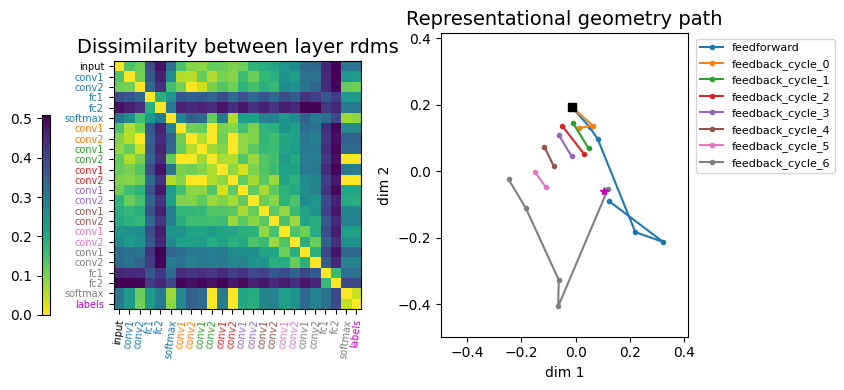

In [45]:
rep_path(features, model_colors, labels)

## Only Conv1

In [46]:
features_conv1 = dict()
for k,v in features.items():
    features_conv1[k] = dict()
    features_conv1[k]['conv1'] = v['conv1']

/home/sjcho/Projects/PCN-with-Global-Recurrent-Processing/helpers.py:199: RuntimeWarning: invalid value encountered in arccos
  rdms_comp = np.arccos(rdms_comp)
/home/sjcho/Projects/PCN-with-Global-Recurrent-Processing/helpers.py:254: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


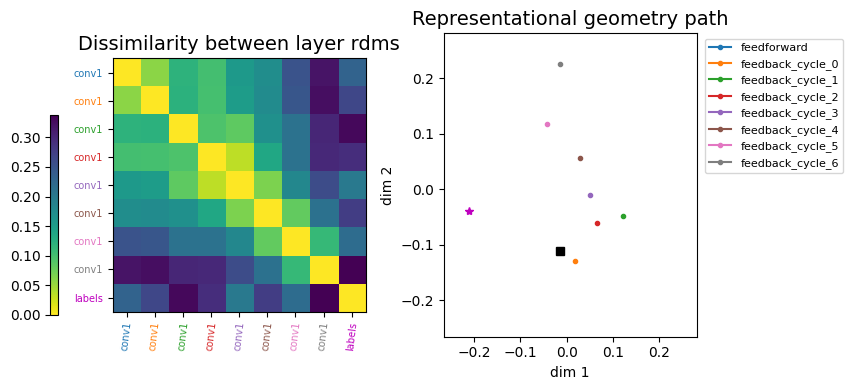

In [47]:
rep_path(features_conv1, model_colors, labels)

## Only Conv2

In [48]:
features_conv2 = dict()
for k,v in features.items():
    features_conv2[k] = dict()
    features_conv2[k]['conv2'] = v['conv2']

/home/sjcho/Projects/PCN-with-Global-Recurrent-Processing/helpers.py:199: RuntimeWarning: invalid value encountered in arccos
  rdms_comp = np.arccos(rdms_comp)
/home/sjcho/Projects/PCN-with-Global-Recurrent-Processing/helpers.py:254: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


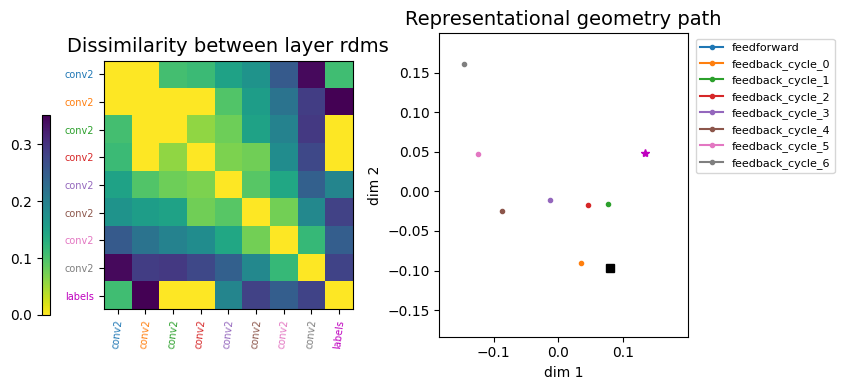

In [49]:
rep_path(features_conv2, model_colors, labels)